In [2]:
# Import packages
import os
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
#import missingno as msno

import zipfile
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# importing data aggregated by day
df = pd.read_csv('../data/daily_merged_hydro_climate.csv')
df_climate_last_month = pd.read_csv("../data/climate_data.csv")

In [4]:
# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])
df_climate_last_month['Date Time'] = pd.to_datetime(df_climate_last_month['Date Time'])
# print(df.date.max())
# print(df_climate_last_month['Date Time'].max())
#df_climate_last_month = df_climate_last_month[df_climate_last_month['Date Time']>df.date.max()].copy().reset_index()
# print(df['Snowfall (mm)_sum'].value_counts())
# print(df_climate_last_month['Snowfall (mm)'].value_counts())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136409 entries, 0 to 136408
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            136409 non-null  datetime64[ns]
 1   Source                          136409 non-null  object        
 2   current_mean                    136409 non-null  float64       
 3   current_max                     136409 non-null  float64       
 4   current_std                     136409 non-null  float64       
 5   power_factor_mean               136409 non-null  float64       
 6   kwh_sum                         136409 non-null  float64       
 7   Temperature (°C)_mean           136409 non-null  float64       
 8   Temperature (°C)_min            136409 non-null  float64       
 9   Temperature (°C)_max            136409 non-null  float64       
 10  Dewpoint Temperature (°C)_mean  136409 non-null  float64

In [5]:
aggregated_df_last = df_climate_last_month.resample("1D", on="Date Time").agg({
    'Date Time': "mean",
    'Temperature (°C)': ["mean", "min", "max"],
    'Dewpoint Temperature (°C)': ["mean", "min", "max"],
    'V Wind Component (m/s)': 'mean',
    'U Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum', # Consider 'mean' if this is already a daily total per user
    'Snowfall (mm)': 'sum',        # Consider 'mean' if this is already a daily total per user
    'Snow Cover (%)': 'mean'
}).reset_index(())

# Flatten MultiIndex columns
aggregated_df_last.columns = [f"{col}_{stat}" for col, stat in aggregated_df_last.columns]
aggregated_df_last.columns = aggregated_df_last.columns.str.rstrip('_')

aggregated_df_last = aggregated_df_last.rename(columns={
    "Date Time_mean": "Date Time"
    })
# print(aggregated_df_last.info())

In [6]:
# aggregated_df_last.head()

In [7]:
# df.head()

--- Aggregating Data ---
Aggregated data shape: (479, 7)

--- Generating Plots ---


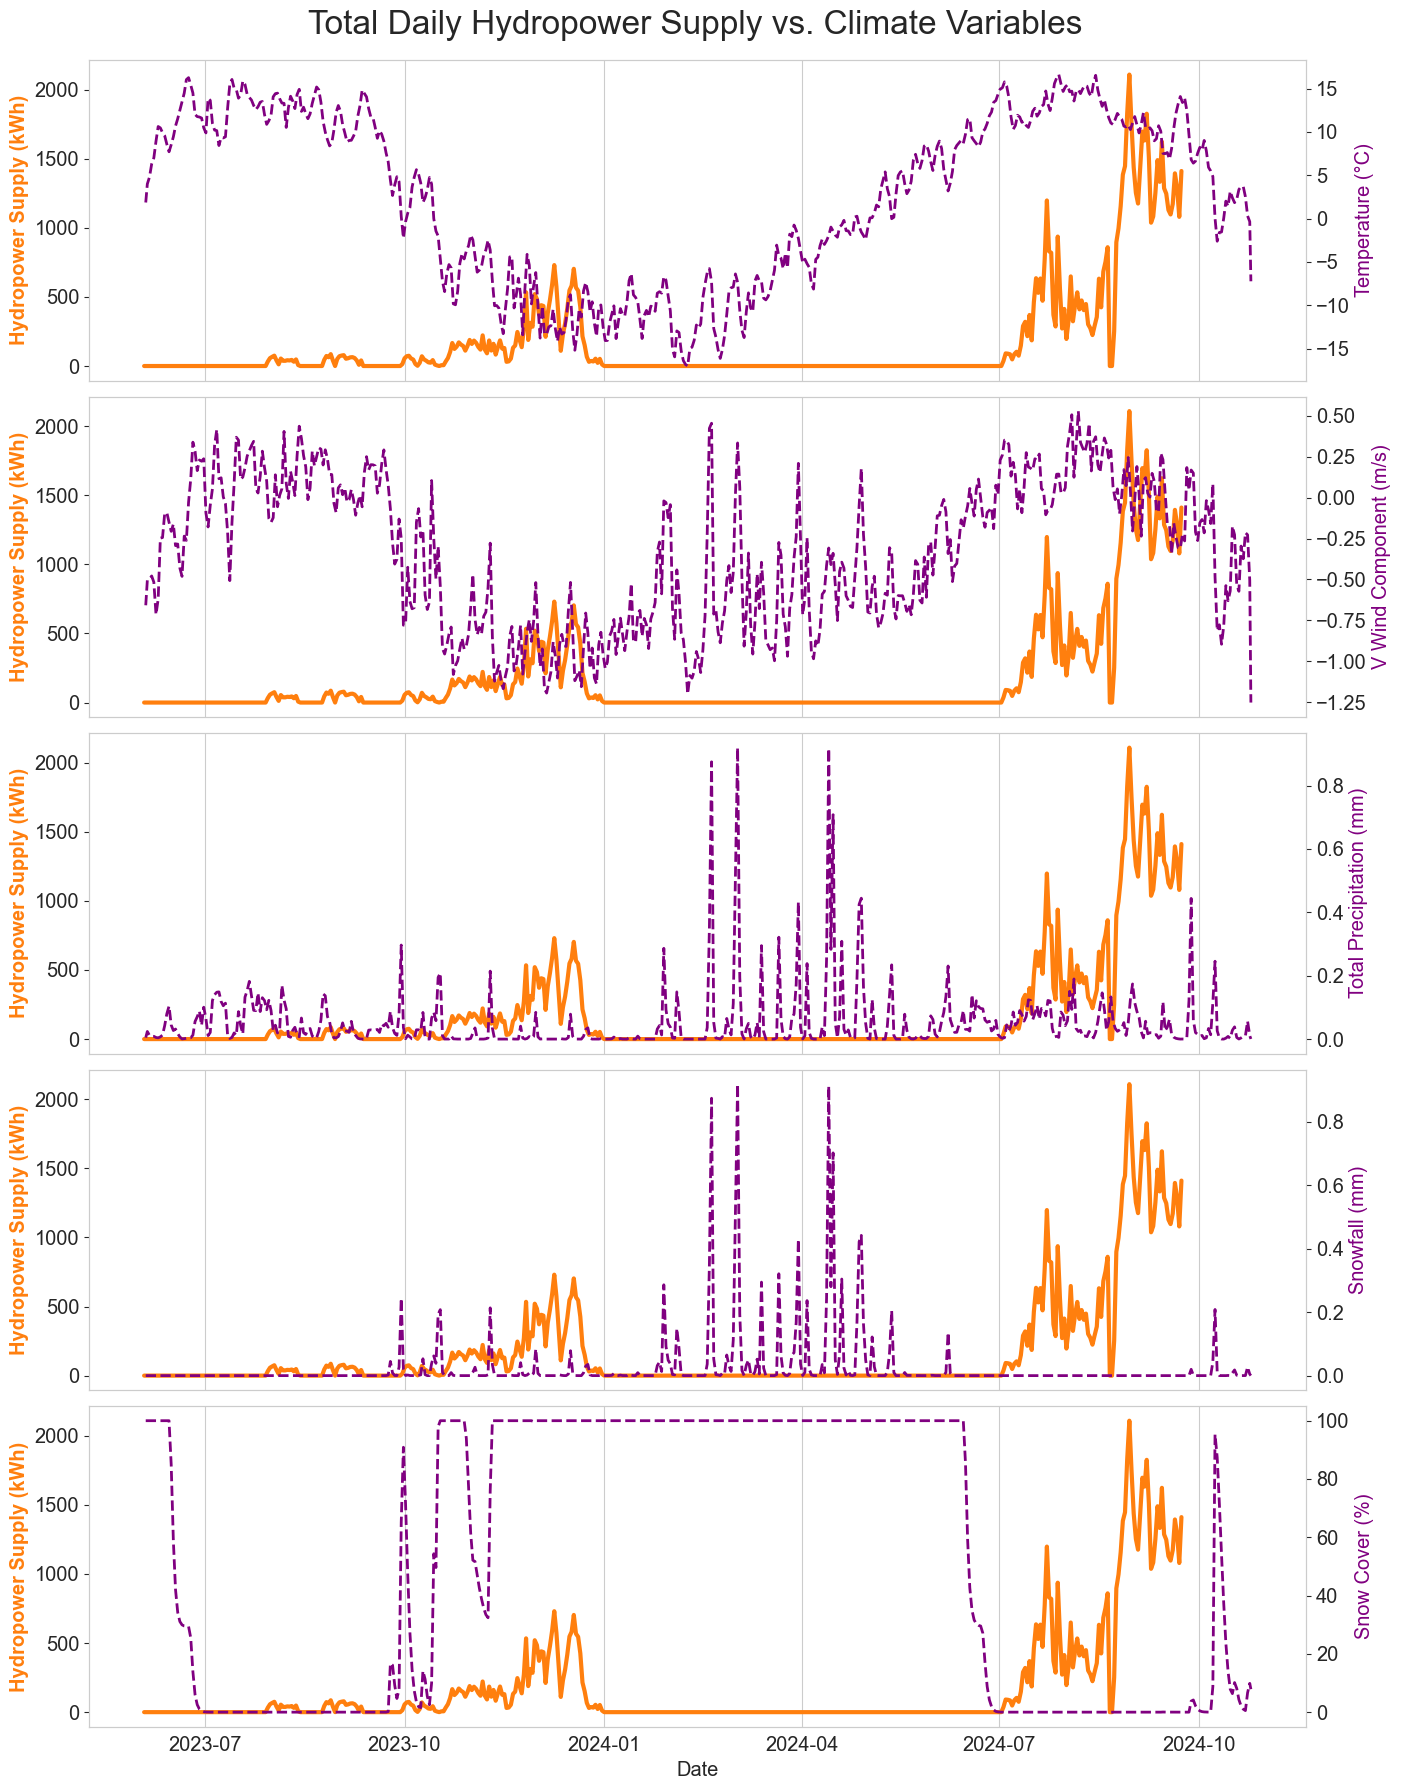

Aggregated dual-axis plot generated successfully.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For better date formatting
import numpy as np

# --- ASSUMPTION: Your daily data is loaded into a DataFrame called `df`
# df = pd.read_csv('daily_merged_hydro_climate.csv') # Uncomment if needed

# --- 1. Aggregate Data by Date ---
print("--- Aggregating Data ---")
# Group by 'date' and calculate:
# - Sum for kwh_sum (total consumption)
# - Mean for climate variables (average conditions)
aggregated_df = df.groupby('date').agg({
    'kwh_sum': 'sum',                 # Total daily consumption
    'Temperature (°C)_mean': 'mean',
    'V Wind Component (m/s)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'mean', # Consider 'mean' if this is already a daily total per user
    'Snowfall (mm)_sum': 'mean',        # Consider 'mean' if this is already a daily total per user
    'Snow Cover (%)_mean': 'mean'
}).reset_index()

# Sort the aggregated data by date for correct plotting
aggregated_df = aggregated_df.sort_values('date').reset_index(drop=True)

# print("Aggregated data summary:")
# print(aggregated_df.head())
print(f"Aggregated data shape: {aggregated_df.shape}")

# --- 2. Define Climate Variables to Plot (against Total Energy) ---
# List of climate variables to plot
climate_vars = [
    'Temperature (°C)_mean',
    'V Wind Component (m/s)_mean',
    'Total Precipitation (mm)_sum',
    'Snowfall (mm)_sum',
    'Snow Cover (%)_mean'
]

# --- 3. Create the Multi-Panel Plot ---
n_plots = len(climate_vars)
n_cols = 1
n_rows = n_plots

# Create the figure and axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 3.5 * n_rows))
# Ensure axes is always a list
if n_plots == 1:
    axes = [axes]

label_dict = {
    'Temperature (°C)_mean': 'Temperature (°C)',
    'V Wind Component (m/s)_mean': 'V Wind Component (m/s)',
    'Total Precipitation (mm)_sum': 'Total Precipitation (mm)',
    'Snowfall (mm)_sum': 'Snowfall (mm)',
    'Snow Cover (%)_mean': 'Snow Cover (%)'
}

# --- 4. Plot Each Climate Variable vs Total Energy ---
print("\n--- Generating Plots ---")
for i, climate_var in enumerate(climate_vars):
    ax = axes[i]

    if climate_var in aggregated_df.columns and not aggregated_df[climate_var].isna().all():
        # --- Plot 1: Total Daily Energy Consumption (Orange) ---
        line1 = ax.plot(aggregated_df['date'], aggregated_df['kwh_sum'],
                linestyle='-', linewidth=3, #marker='o', markersize=2,
                color='tab:orange',  # 🔥 Orange for energy
                label='Hydropower Supply (kWh)')

        # --- Plot 2: Climate Variable (Light Blue) ---
        ax2 = ax.twinx()
        line3 = ax2.plot(aggregated_df_last['Date Time'], aggregated_df_last[climate_var],
                linestyle='--', linewidth=2, #marker='s', markersize=2,
                color='purple')
        # --- Formatting ---
        ax.set_ylabel('Hydropower Supply (kWh)', color='tab:orange', fontsize='x-large', weight='bold')
        ax.tick_params(axis='y', which='major', labelsize='x-large')
        ax2.set_ylabel(label_dict[climate_var], color='purple', fontsize='x-large')
        ax2.tick_params(axis='y', which='major', labelsize='x-large')

        if i < len(climate_vars)-1:
            plt.xticks([pd.to_datetime("2023-07"), pd.to_datetime("2023-10"),
                        pd.to_datetime("2024-01"), pd.to_datetime("2024-04"),
                        pd.to_datetime("2024-07"), pd.to_datetime("2024-10")],
                        ['','','','','',''])
        else:
            plt.xticks([pd.to_datetime("2023-07"), pd.to_datetime("2023-10"),
                        pd.to_datetime("2024-01"), pd.to_datetime("2024-04"),
                        pd.to_datetime("2024-07"), pd.to_datetime("2024-10")],
                        ['','','','','',''])
        

        # ax.set_title(f'Total Daily Energy vs. {climate_var}')

        # Remove grid (as requested)
        ax.grid(visible=None, which='major', axis='y')
        ax2.grid(visible=None, which='major', axis='both')

        # Optional: Hide tick marks (clean look)
        # ax.tick_params(axis='y', which='both', length=0)
        # ax2.tick_params(axis='y', which='both', length=0)

        # --- Legend ---
        # if i == 0:
        #     lines = line1 + line3
        #     labels = [l.get_label() for l in lines]
        #     ax.legend(lines, labels, loc='upper center')

    else:
        ax.text(0.5, 0.5, f'Data not available\n({climate_var})', 
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'Total Daily Hydropower Supply vs. {climate_var}')


# --- 5. Format Shared X-axis ---
axes[-1].set_xlabel('Date', fontsize='x-large') # Label only the bottom subplot
axes[-1].set_xticks([pd.to_datetime("2023-07"), pd.to_datetime("2023-10"),
                     pd.to_datetime("2024-01"), pd.to_datetime("2024-04"),
                     pd.to_datetime("2024-07"), pd.to_datetime("2024-10")],
                     [pd.to_datetime("2023-07"), pd.to_datetime("2023-10"),
                     pd.to_datetime("2024-01"), pd.to_datetime("2024-04"),
                     pd.to_datetime("2024-07"), pd.to_datetime("2024-10")], fontsize='x-large') # Label only the bottom subplot

# Improve date formatting on the shared x-axis using the bottom axis
bottom_ax = axes[-1]
# Determine a suitable date locator based on data range
date_range = aggregated_df['date'].max() - aggregated_df['date'].min()
if date_range.days > 365 * 3:
    bottom_ax.xaxis.set_major_locator(mdates.YearLocator())
    bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
elif date_range.days > 180:
    bottom_ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
else:
    bottom_ax.xaxis.set_major_locator(mdates.MonthLocator())
    bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate labels for better readability
# plt.setp(bottom_ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- 6. Finalize and Display ---
plt.tight_layout() # Adjust layout to prevent clipping
plt.suptitle('Total Daily Hydropower Supply vs. Climate Variables', fontsize=24, y=1.02)
plt.savefig('../images/Hydropower_supply_vs_climate_vars.png')
plt.show()

print("Aggregated dual-axis plot generated successfully.")
